## Using autoencoders to find the anomalous transactions. 


The data from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). 

Follows the approach of [this notebook](https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb)

In [33]:
import pandas as pd

## Importing data 

In [34]:
df = pd.read_csv('./creditcard.csv')

In [35]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [36]:
df.shape

(284807, 31)

In [37]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There are no null values

In [38]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [39]:
df['Class'].value_counts()[1] / df['Class'].value_counts()[0]

0.0017304750013189597

We have about 0.17% fraud cases. Let's separate the fraud and valid transactions

In [40]:
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]

In [41]:
fraud.shape

(492, 31)

In [42]:
valid.shape

(284315, 31)

Let's look at the distribution of the amount in fraud vs. valid case

In [43]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [44]:
valid.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Let's have a more graphical representation for the distribution of the amount

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

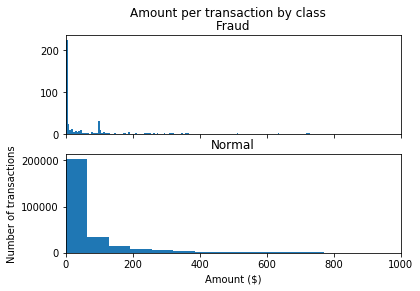

In [46]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
#sharex=True allows both the subplots to share the same X axis. 
f.suptitle('Amount per transaction by class')

numberBins = 400

ax1.hist(fraud.Amount, bins=numberBins);
ax1.set_title('Fraud')

ax2.hist(valid.Amount, bins=numberBins);
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of transactions')
plt.xlim((0, 1000));
#plt.yscale('log')

Let's look at te distribution of time for fraud vs. valid transactions. 

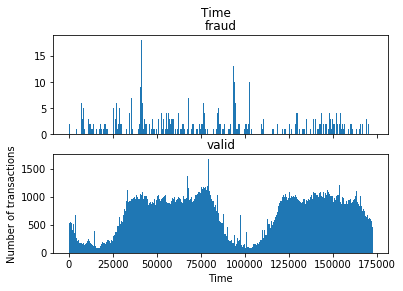

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

f.suptitle('Time')

ax1.hist(fraud.Time, bins=numberBins)
ax1.set_title('fraud')

ax2.hist(valid.Time, bins=numberBins)
ax2.set_title('valid')

plt.xlabel('Time')
plt.ylabel('Number of transactions');

Let's also look at the time of the transaction vs. amount for fraud and normal cases.

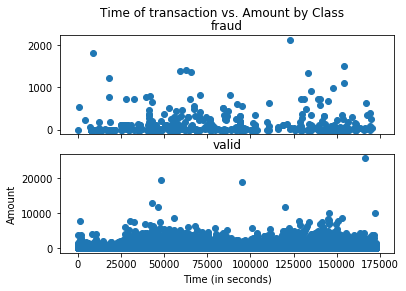

In [48]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs. Amount by Class')

ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('fraud')

ax2.scatter(valid.Time, valid.Amount)
ax2.set_title('valid');

plt.xlabel('Time (in seconds)');
plt.ylabel('Amount');

In [49]:
df.Time.head(10)

0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
5    2.0
6    4.0
7    7.0
8    7.0
9    9.0
Name: Time, dtype: float64

The time here is the time in seconds from the first transaction. We see (as expected) that it doesn't have any impact on whether the transaction is fraud or not. 

## Preparing the data

We drop the time column and standardize the Amount column.

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
data = df.drop(['Time'], axis = 'columns')

In [52]:
data['Amount'].head()

0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64

In [53]:
data['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [54]:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [55]:
data['Amount'].head()

0    0.244964
1   -0.342475
2    1.160686
3    0.140534
4   -0.073403
Name: Amount, dtype: float64

In [56]:
data['Amount'].describe()

count    2.848070e+05
mean     3.202236e-16
std      1.000002e+00
min     -3.532294e-01
25%     -3.308401e-01
50%     -2.652715e-01
75%     -4.471707e-02
max      1.023622e+02
Name: Amount, dtype: float64

We train the autoencoder only on the valid transactions. 

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
Xtrain, Xtest = train_test_split(data, test_size = 0.2, random_state = 42)

In [59]:
Xtrain.Class.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [60]:
Xtrain = Xtrain[Xtrain.Class == 0]

Xtrain = Xtrain.drop(['Class'], axis = 'columns')

ytest = Xtest['Class']
Xtest = Xtest.drop('Class', axis = 'columns')

In [61]:
Xtrain.shape

(227451, 29)

## Building model

As a first pass, we construct an Autoencoder with 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoding and the last two for the decoding. Additionally, L1 regularization will be used during training

In [62]:
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers

In [65]:
layer1 = 14
layer2 = 7
layer3 = 7
layer4 = Xtrain.shape[1]

In autoencoders, the final has the same number of nodes as number of features. 

In [67]:
autoencoder = Sequential()

autoencoder.add(Dense(layer1, activation='tanh', activity_regularizer=regularizers.l1(10e-5), \
          input_shape=(Xtrain.shape[1],)))

autoencoder.add(Dense(layer2, activation='relu'))

autoencoder.add(Dense(layer3, activation='tanh'))

autoencoder.add(Dense(layer4, activation='relu'))

From the documentation: 

#### Example

```python
    # as first layer in a sequential model:
    model = Sequential()
    model.add(Dense(32, input_shape=(16,)))
    # now the model will take as input arrays of shape (*, 16)
    # and output arrays of shape (*, 32)

    # after the first layer, you don't need to specify
    # the size of the input anymore:
    model.add(Dense(32))

In [70]:
Xtrain.shape[1]

29

In [69]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_8 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


In [35]:
Xtrain.shape

(227451, 29)

In [36]:
14 * 30

420

In [37]:
15 * 7

105

In [38]:
8 * 7

56

In [39]:
8 * 29

232

Note how the number of parameters check out. Note that at each step, we have a bias unit added as well. 

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [71]:
numEpoch = 100
batchSize = 32

In [72]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [75]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [76]:
checkpointer = ModelCheckpoint(filepath="autoencoderModel2.h5",
                               verbose=0,
                               save_best_only=True)

In [77]:
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [78]:
history = autoencoder.fit(Xtrain, Xtrain,
                    epochs=numEpoch,
                    batch_size=batchSize,
                    shuffle=True,
                    validation_data=(Xtest, Xtest),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, EarlyStopping(patience=3)]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.8302 - acc: 0.5498 - val_loss: 0.8080 - val_acc: 0.6344
Epoch 2/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7712 - acc: 0.6288 - val_loss: 0.7936 - val_acc: 0.6393
Epoch 3/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7627 - acc: 0.6390 - val_loss: 0.7882 - val_acc: 0.6482
Epoch 4/100
227451/227451 [==============================] - 11s 47us/step - loss: 0.7582 - acc: 0.6455 - val_loss: 0.7830 - val_acc: 0.6551
Epoch 5/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.7550 - acc: 0.6526 - val_loss: 0.7823 - val_acc: 0.6499
Epoch 6/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7524 - acc: 0.6570 - val_loss: 0.7793 - val_acc: 0.6592
Epoch 7/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7510 - acc: 0.6609

## Let's tune the model parameters

**1. Increasing number of nodes**

In [86]:
layer1 = Xtrain.shape[1]
layer2 = 7
layer3 = 7
layer4 = Xtrain.shape[1]

In [87]:
autoencoder = Sequential()

autoencoder.add(Dense(layer1, activation='tanh', activity_regularizer=regularizers.l1(10e-5), \
          input_shape=(Xtrain.shape[1],)))

autoencoder.add(Dense(layer2, activation='relu'))

autoencoder.add(Dense(layer3, activation='tanh'))

autoencoder.add(Dense(layer4, activation='relu'))

In [88]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [89]:
history = autoencoder.fit(Xtrain, Xtrain,
                    epochs=numEpoch,
                    batch_size=batchSize,
                    shuffle=True,
                    validation_data=(Xtest, Xtest),
                    verbose=1,
                    callbacks=[EarlyStopping(patience=3)]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.8168 - acc: 0.5989 - val_loss: 0.7988 - val_acc: 0.6577
Epoch 2/100
227451/227451 [==============================] - 11s 48us/step - loss: 0.7579 - acc: 0.6592 - val_loss: 0.7834 - val_acc: 0.6662
Epoch 3/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7473 - acc: 0.6654 - val_loss: 0.7793 - val_acc: 0.6644
Epoch 4/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7407 - acc: 0.6710 - val_loss: 0.7651 - val_acc: 0.6775
Epoch 5/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7291 - acc: 0.6784 - val_loss: 0.7582 - val_acc: 0.6763
Epoch 6/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.7257 - acc: 0.6816 - val_loss: 0.7623 - val_acc: 0.6773
Epoch 7/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.7238 - acc: 0.6845

**2.1 Changing the activation function**

In [90]:
autoencoder = Sequential()

autoencoder.add(Dense(layer1, activation='relu', activity_regularizer=regularizers.l1(10e-5), \
          input_shape=(Xtrain.shape[1],)))

autoencoder.add(Dense(layer2, activation='relu'))

autoencoder.add(Dense(layer3, activation='relu'))

autoencoder.add(Dense(layer4, activation='relu'))

In [91]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [92]:
history = autoencoder.fit(Xtrain, Xtrain,
                    epochs=numEpoch,
                    batch_size=batchSize,
                    shuffle=True,
                    validation_data=(Xtest, Xtest),
                    verbose=1,
                    callbacks=[EarlyStopping(patience=3)]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 13s 55us/step - loss: 0.8322 - acc: 0.4180 - val_loss: 0.8189 - val_acc: 0.4951
Epoch 2/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7746 - acc: 0.5069 - val_loss: 0.8027 - val_acc: 0.5203
Epoch 3/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7630 - acc: 0.5260 - val_loss: 0.7965 - val_acc: 0.5351
Epoch 4/100
227451/227451 [==============================] - 11s 49us/step - loss: 0.7586 - acc: 0.5321 - val_loss: 0.7900 - val_acc: 0.5407
Epoch 5/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.7562 - acc: 0.5366 - val_loss: 0.7904 - val_acc: 0.5334
Epoch 6/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.7549 - acc: 0.5345 - val_loss: 0.7861 - val_acc: 0.5396
Epoch 7/100
227451/227451 [==============================] - 12s 52us/step - loss: 0.7542 - acc: 0.5346

**2.2 Changing the activation function**

In [93]:
autoencoder = Sequential()

autoencoder.add(Dense(layer1, activation='tanh', activity_regularizer=regularizers.l1(10e-5), \
          input_shape=(Xtrain.shape[1],)))

autoencoder.add(Dense(layer2, activation='tanh'))

autoencoder.add(Dense(layer3, activation='tanh'))

autoencoder.add(Dense(layer4, activation='tanh'))

In [94]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [95]:
history = autoencoder.fit(Xtrain, Xtrain,
                    epochs=numEpoch,
                    batch_size=batchSize,
                    shuffle=True,
                    validation_data=(Xtest, Xtest),
                    verbose=1,
                    callbacks=[EarlyStopping(patience=3)]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 12s 52us/step - loss: 0.7391 - acc: 0.4212 - val_loss: 0.7140 - val_acc: 0.4333
Epoch 2/100
227451/227451 [==============================] - 11s 50us/step - loss: 0.6803 - acc: 0.4437 - val_loss: 0.7002 - val_acc: 0.4565
Epoch 3/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.6713 - acc: 0.4486 - val_loss: 0.6949 - val_acc: 0.4506
Epoch 4/100
227451/227451 [==============================] - 12s 51us/step - loss: 0.6676 - acc: 0.4476 - val_loss: 0.6920 - val_acc: 0.4476
Epoch 5/100
227451/227451 [==============================] - 12s 52us/step - loss: 0.6651 - acc: 0.4418 - val_loss: 0.6897 - val_acc: 0.4499
Epoch 6/100
227451/227451 [==============================] - 12s 53us/step - loss: 0.6634 - acc: 0.4390 - val_loss: 0.6879 - val_acc: 0.4382
Epoch 7/100
227451/227451 [==============================] - 12s 54us/step - loss: 0.6620 - acc: 0.4361

## Evaluation

In [49]:
type(history)

dict

In [50]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [53]:
history['loss'][:20]

[0.7761044334021687,
 0.7728777687832956,
 0.7701167724167559,
 0.7679852686638681,
 0.7665447594122871,
 0.7649855586480994,
 0.7641122535459218,
 0.7633742649144221,
 0.7628157844590668,
 0.7624578003127837,
 0.7620371639884207,
 0.7618202296435831,
 0.7616840608213225,
 0.7614316767008104,
 0.7614041989700511,
 0.761212007623036,
 0.7613907455461164,
 0.7611809040592742,
 0.7608114649746116,
 0.7606323724206532]

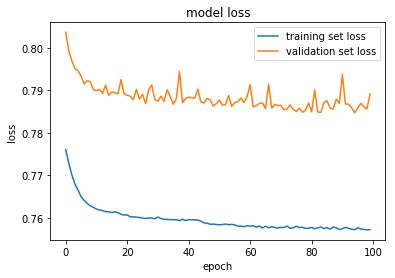

In [54]:
plt.plot(history['loss']);
plt.plot(history['val_loss']);
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set loss', 'validation set loss']);

**Let's now look at the reconstruction error**

In [55]:
predictions = autoencoder.predict(Xtest)

In [56]:
predictions

array([[0.        , 5.6368365 , 0.        , ..., 1.1145061 , 0.        ,
        0.        ],
       [0.4581251 , 0.        , 0.08737671, ..., 0.        , 0.        ,
        0.        ],
       [1.3623562 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.09652805, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.6890912 , 1.6088597 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.0420175 , 0.3029219 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [57]:
import numpy as np

In [58]:
Xtest.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1.102834
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,1.726255
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,-0.229289
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.347232
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.349671


In [59]:
np.power(Xtest - predictions, 2).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
43428,273.125419,8.691502,347.817024,90.356308,190.269430,8.022514,278.946592,56.510459,72.370047,199.097305,...,2.294993,1.417859,1.271640,9.228744,0.453550,1.998547,0.214149,9.816199,1.087441,1.216242
49906,0.013998,7.528138,0.049038,1.920246,2.106601,0.270260,0.274973,0.003564,0.097142,0.319238,...,0.256080,0.045555,0.888353,0.277538,1.338630,0.096852,0.557481,0.001681,0.010412,2.979957
29474,0.001386,0.348928,0.028432,1.060798,0.291391,0.001636,0.507751,0.000005,0.944292,0.003604,...,0.045317,0.010485,0.002116,0.027769,0.656505,0.255109,0.053982,0.000130,0.000021,0.052573
276481,0.186685,0.014945,2.786765,0.251617,0.096685,0.397715,0.002910,0.343425,0.234949,1.895160,...,0.059845,0.128832,0.763287,0.031913,0.000295,0.043011,0.024887,0.056352,0.000004,0.120570
278846,0.014773,0.018877,1.031929,0.107105,0.033189,0.915027,0.000379,0.025839,0.131944,0.067315,...,0.065175,0.056951,0.379950,0.120440,0.003790,0.129741,0.030531,0.006091,0.004980,0.122270


In [60]:
np.mean(np.power(Xtest - predictions, 2), axis = 'rows').head()

V1    2.684888
V2    1.775939
V3    1.541900
V4    0.991421
V5    1.069581
dtype: float64

In [61]:
np.mean(np.power(Xtest - predictions, 2), axis = 'columns').head()

43428     79.818455
49906      0.926384
29474      0.221266
276481     0.373049
278846     0.154457
dtype: float64

In [62]:
mse = np.mean(np.power(Xtest - predictions, 2), axis = 'columns')

In [63]:
reconstructionErrorDF = pd.DataFrame({'mse': mse, 'trueClass': ytest})

In [64]:
reconstructionErrorDF.head()

,mse,trueClass
43428,79.818455,1
49906,0.926384,0
29474,0.221266,0
276481,0.373049,0
278846,0.154457,0


In [65]:
validReconstructionErrorDf = reconstructionErrorDF[reconstructionErrorDF['trueClass'] == 0]

In [66]:
fraudReconstructionErrorDF = reconstructionErrorDF[reconstructionErrorDF['trueClass'] == 1]

In [67]:
validReconstructionErrorDf.shape

(56864, 2)

In [68]:
fraudReconstructionErrorDF.shape

(98, 2)

In [69]:
fraudReconstructionErrorDF.mse.describe()

count     98.000000
mean      30.118440
std       44.554990
min        0.166711
25%        3.650527
50%       10.425117
75%       49.902009
max      250.983315
Name: mse, dtype: float64

In [70]:
validReconstructionErrorDf.mse.describe()

count    56864.000000
mean         0.730182
std          2.722149
min          0.028873
25%          0.245117
50%          0.392474
75%          0.623275
max        168.874743
Name: mse, dtype: float64

We see that the reconstruction error is higher for the fraud examples.

In [71]:
import seaborn as sns

In [72]:
sns.set(style='whitegrid', font_scale=1.5)

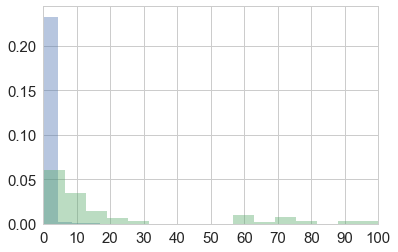

In [126]:
sns.distplot(validReconstructionErrorDf.mse.values, bins = 40, norm_hist=True, kde=False);
sns.distplot(fraudReconstructionErrorDF.mse.values, bins = 40, norm_hist=True, kde=False);
plt.xlim((0, 100));
plt.xticks(np.linspace(0, 100, 11));

In [174]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, \
                             classification_report, f1_score, precision_score)

In [75]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.trueClass, reconstructionErrorDF.mse)

The first parameter of the roc_curve function is y_true (the true binary labels either {0, 1} or {-1, 1}). 

The second parameter of the roc_curve is y_score. 
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers).

The output are as follows: 

**fpr** : array, shape = [>2]

Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i].

** tpr ** : array, shape = [>2]

Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].

** thresholds **: array, shape = [n_thresholds]

Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1.

In [76]:
thresholds

array([2.50983315e+02, 1.91728688e+02, 1.53529397e+02, ...,
       4.35756158e-02, 4.34579237e-02, 2.88734837e-02])

In [77]:
fpr

array([0.00000000e+00, 0.00000000e+00, 5.27574564e-05, ...,
       9.99648284e-01, 9.99683455e-01, 1.00000000e+00])

In [78]:
tpr

array([0.01020408, 0.02040816, 0.02040816, ..., 1.        , 1.        ,
       1.        ])

TPR (Recall) = TP/ (actual yes) = TP /(TP + FN)

FPR = FP / (actual no) = FP / (TN + FP)

In [79]:
fpr.shape

(1026,)

In [80]:
tpr.shape

(1026,)

In [81]:
thresholds.shape

(1026,)

In [82]:
reconstructionErrorDF.trueClass.shape

(56962,)

In [83]:
rocAuc = auc(fpr, tpr)

In [89]:
rocAuc

0.9585606330320535

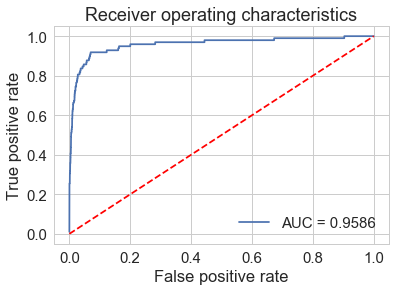

In [98]:
plt.plot(fpr,tpr, label = 'AUC = %0.4f'% rocAuc);
plt.title('Receiver operating characteristics');
plt.legend(loc='lower right');
plt.plot([0,1], [0,1], 'r--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');

In [99]:
reconstructionErrorDF.columns

Index(['mse', 'trueClass'], dtype='object')

In [100]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.trueClass, mse)

Note that the input arguments of the precision_recall_curve are the same as that of the roc_curve. 
See the note below the roc_curve. The mean-squared reconstruction error here is a proxy for 'y_score' of the estimated probabilities. 

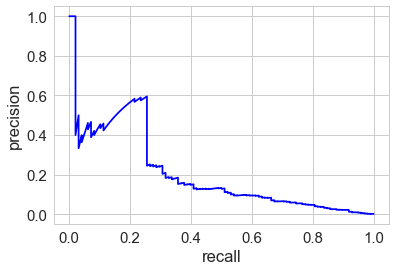

In [107]:
plt.plot(recall, precision, 'b', label = 'Precision-recall curve');
plt.xlabel('recall');
plt.ylabel('precision');

In [113]:
th #thresholds output from the precision_recall curve function

array([1.66710672e-01, 1.66711371e-01, 1.66712548e-01, ...,
       1.68874743e+02, 1.91728688e+02, 2.50983315e+02])

In [114]:
precision

array([0.00190447, 0.00188507, 0.00188511, ..., 1.        , 1.        ,
       1.        ])

In [115]:
recall

array([1.        , 0.98979592, 0.98979592, ..., 0.02040816, 0.01020408,
       0.        ])

We see from above that:

high threshold => high precision and low recall.

low theshold => low precision and high recall. 

A high area under the precision recall curve represents both high recall and high precision where high precision relates to a low false positive rate and a high recall relates to a low false negative rate. 

In [117]:
len(precision)

50856

In [110]:
len(th)

50855

In [112]:
thresholds #thresholds output from the roc curve function

array([2.50983315e+02, 1.91728688e+02, 1.53529397e+02, ...,
       4.35756158e-02, 4.34579237e-02, 2.88734837e-02])

In [111]:
len(thresholds)

1026

Let's look at the precision-threshold and recall-threshold curves.

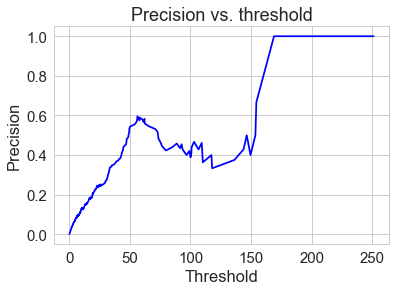

In [124]:
plt.plot(th, precision[1:], 'b');
plt.xlabel('Threshold');
plt.ylabel('Precision');
plt.title('Precision vs. threshold');

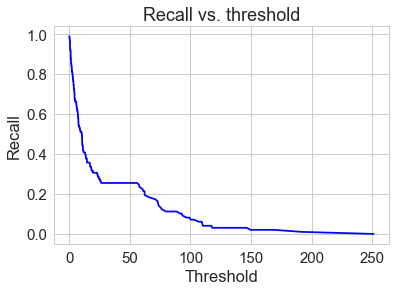

In [125]:
plt.plot(th, recall[1:], 'b');
plt.xlabel('Threshold');
plt.ylabel('Recall');
plt.title('Recall vs. threshold');

### Predictions

In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). 

Based on the graph below, I chose the threshold to be 4.1.

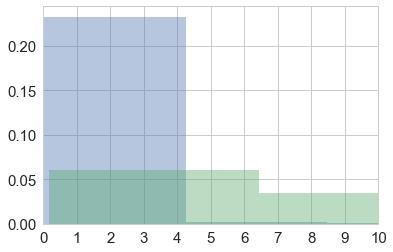

In [128]:
sns.distplot(validReconstructionErrorDf.mse.values, bins = 40, norm_hist=True, kde=False);
sns.distplot(fraudReconstructionErrorDF.mse.values, bins = 40, norm_hist=True, kde=False);
plt.xlim((0, 10));
plt.xticks(np.linspace(0, 10, 11));

In [ ]:
groups  =  error_dferror_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [146]:
thresholdMSE = 4.1

In [144]:
ax.get_xlim()[0]

-14240.150000000001

In [147]:
ax.get_xlim()

(-14240.150000000001, 299043.15)

In [130]:
groups

In [136]:
for name, group in groups:
    
    print("name:", name)
    print("group:", group)
    print("group.index:", group.index)

name: 0
group:              mse  trueClass
49906   0.926384          0
29474   0.221266          0
276481  0.373049          0
278846  0.154457          0
101565  0.985582          0
260880  0.181401          0
214337  0.411403          0
201575  0.554766          0
81055   2.662419          0
134976  0.297906          0
237701  0.385238          0
256836  0.486059          0
97650   0.205384          0
158290  0.678566          0
246697  1.527952          0
68279   0.781315          0
267585  0.766597          0
26525   0.527700          0
74422   1.194972          0
206357  0.360036          0
257395  0.419868          0
283656  1.209072          0
231156  0.469845          0
38442   1.057967          0
225485  0.459399          0
92410   0.129582          0
10828   0.824117          0
61461   0.173722          0
134354  0.456501          0
45265   0.474566          0
...          ...        ...
97068   0.468987          0
127928  0.195281          0
254929  1.666512          0
20374

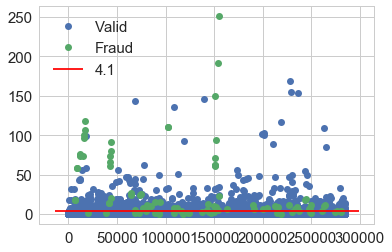

In [162]:
groups  =  reconstructionErrorDF.groupby('trueClass')
fig, ax = plt.subplots()

for name, group in groups:
    
    ax.plot(group.index, group.mse, marker = 'o', linestyle='', 
           label="Fraud" if name == 1 else "Valid")
    
ax.hlines(thresholdMSE, ax.get_xlim()[0], ax.get_xlim()[1], colors = "r", zorder = 10, label=thresholdMSE);

ax.legend();

In [133]:
reconstructionErrorDF

,mse,trueClass
43428,79.818455,1
49906,0.926384,0
29474,0.221266,0
276481,0.373049,0
278846,0.154457,0
101565,0.985582,0
260880,0.181401,0
214337,0.411403,0
201575,0.554766,0
81055,2.662419,0


Let's look at the confusion matrix for the given threshold. 

In [163]:
yPred = [1 if val > thresholdMSE else 0 for val in reconstructionErrorDF.mse]

In [165]:
confMatrixMSE = confusion_matrix(reconstructionErrorDF.trueClass, yPred)

In [166]:
confMatrixMSE

array([[55791,  1073],
       [   27,    71]])

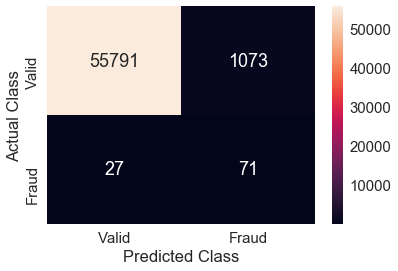

In [173]:
sns.heatmap(confMatrixMSE, xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"], annot=True, fmt='d');
plt.xlabel('Predicted Class');
plt.ylabel('Actual Class');

In [175]:
precision_score(reconstructionErrorDF.trueClass, yPred)

0.062062937062937064

In [176]:
71/ (71 + 1073) # precision

0.062062937062937064

In [178]:
(1073+ 71) / 71 # FPR in Bank terms

16.112676056338028

In [179]:
recall_score(reconstructionErrorDF.trueClass, yPred)

0.7244897959183674

In [181]:
71/ (71 + 27) # recall

0.7244897959183674

As we have seen, we can change the precision/ recall tradeoff by varying the thresholdMSE.